# Setup

For this to work, `RT.FinFout()` needs to accept `**kwargs`, which it currently does not do. So this script only works after two tweaks to the sunbather source code. You must add `**kwargs` at the end of the function arguments of `FinFout()`, and then inside it, you must also pass these kwargs to the `project_1D_to_2D()` function, which is called three times!

In [1]:
import sys
sys.path.append('/home/raghav/sunbather/src/')
import tools
import RT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from scipy.integrate import trapezoid
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
import imageio
import matplotlib.patheffects as PathEffects
from matplotlib.collections import PathCollection


#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib widget

/home/raghav/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def speciescolor(species):
    atom = species.split('+')[0] #ions get same color as atom
    colordict = {'H':'black', 'He':'darkblue', 'Li':'blue', 'Be':'violet', 'B':'mediumslateblue',
               'C':'blueviolet', 'N':'green', 'O':'salmon', 'F':'magenta', 'Ne':'pink',
               'Na':'palevioletred', 'Mg':'deeppink', 'Al':'darkorange', 'Si':'royalblue', 'P':'coral',
               'S':'chocolate', 'Cl':'saddlebrown', 'Ar':'sandybrown', 'K':'crimson',
               'Ca':'goldenrod', 'Sc':'gold', 'Ti':'olivedrab', 'V':'olive', 'Cr':'purple',
               'Mn':'limegreen', 'Fe':'darkslategray', 'Co':'mediumaquamarine', 'Ni':'cyan',
               'Cu':'darkturquoise', 'Zn':'teal'}
    return colordict[atom]

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    '''
    Cuts a colormap to a smaller range.
    from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    '''

    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap1 = truncate_colormap(matplotlib.colormaps['twilight'], minval=0.1, maxval=0.9)

In [4]:
def species_to_label(sp):
    '''
    Converts e.g. 'C+4' to r'C$^{4+}$' to use as latex label
    '''
    
    if sp[-1] == '6':
        #spl = sp[:-2] + r'$^{6+}$'
        spl = sp[:-2] + ' VII'
        
    elif sp[-1] == '5':
        #spl = sp[:-2] + r'$^{5+}$'
        spl = sp[:-2] + ' VI'
        
    elif sp[-1] == '4':
        #spl = sp[:-2] + r'$^{4+}$'        
        spl = sp[:-2] + ' V'
        
    elif sp[-1] == '3':
        #spl = sp[:-2] + r'$^{3+}$'        
        spl = sp[:-2] + ' IV' 
        
    elif sp[-1] == '2':
        #spl = sp[:-2] + r'$^{2+}$'
        spl = sp[:-2] + ' III'
        
    elif sp[-1] == '+':
        #spl = sp[:-1] + r'$^{+}$'        
        spl = sp[:-1] + ' II'  
        
    else:
        #spl = sp
        spl = sp + ' I'
    
    return spl

In [5]:
def plot_lfas(ax, lfas, Rroche=None, title=None, altmax=8, sep_line=4000, marker='o', capsize = None, scale_markers=False, fix_labels=False, markersize=None):
    '''
    Makes a standard line-forming radius plot.
    
    lfas: a nested list of all lines to plot, with:
            l[0] : wavelength
            l[1] : species
            l[2] : lfa
            l[3] : lower sigma lfa
            l[4] : upper sigma lfa
            l[5] : line center transit depth (in Fin/Fout, not %)
    '''
        
    tdls = []
    for l in lfas: #we need to loop once to get the transit depths, so we know how to normalize the scatter size
        tdls.append(l[5])
    
    if tdls != []:
        min_tdl, max_tdl = min(tdls), max(tdls) #needed for scatter size scaling
    
    texts, xpoints, ypoints = [], [], []
    for l in lfas:
        sp = l[1].split('[')[0]
        if scale_markers:
            if len(tdls)==1: #if there only is one line, otherwise max-min will result in division by zero.
                ms = 1 
            else:
                ms = 1 + 9*np.sqrt((l[5]-min_tdl)/(max_tdl-min_tdl)) #scatter size is always linear between 1 and 10
        else:
            ms = 1 + 9/5 * min(5, np.sqrt((l[5]-0.001)*100)) #scatter size capped at ms=10 for td=25%
        if (markersize!=None):
            ms = markersize
            #print('here')
        errorbar = ax.errorbar(l[0], l[2], yerr=[[l[3]], [l[4]]], marker=marker, ms=ms, 
                    color=speciescolor(sp), elinewidth=.7, zorder=1./ms, capsize = capsize)
        xpoints.append(l[0])
        ypoints.append(l[2])
        txt = ax.text(l[0], l[2] + l[4], species_to_label(sp), fontsize=12, color=speciescolor(sp), zorder=2)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
        texts.append(txt)


    if Rroche != None:
        if Rroche < altmax:
            ax.axhline(Rroche, linestyle='dashed', lw=.4, c='k', zorder=-1)
    

    if tdls != []:
        legend_elements = []
        if scale_markers:
            for ms in [1,3,6,10]:
                tdval = ((ms - 1)/9)**2 *(max_tdl-min_tdl) + min_tdl
                legend_elements.append(Line2D([0], [0], marker=marker, color='k', label="%.1f" %(tdval*100)+' %', markersize=ms, lw=.7))
        else:
            for tdval, lab in zip([0.001, 0.01, 0.05, 0.25], ['0.1%', '1%', '5%', '>25%']):
                ms = 1 + 9/5 * np.sqrt((tdval-0.001)*100)
                if (markersize!=None):
                    ms = markersize
                   #print('here')
                legend_elements.append(Line2D([0], [0], marker='o', color='k', label=lab, markersize=ms, lw=.7))                
        legend = ax.legend(handles=legend_elements, ncol=2, title='Excess absorption', loc='upper right', fontsize=9, framealpha=0.6)
        legend.get_title().set_fontsize(9)

    
    if len(lfas) == 0:
        ax.text(0.5, 0.5, 'No lines above threshold', fontsize=13, ha='center', va='center',transform=ax.transAxes)
        
    
    ax.set_xscale('log')
    ax.set_xlim(830,12000)
    ax.set_ylim(1, altmax)
    ax.set_xlabel('Wavelength [Å]', fontsize=13)
    ax.set_ylabel(r'Line-forming radius [$R_p$]', fontsize=13)
    if title != None:
        ax.set_title(title)
    if fix_labels:
        adjust_text(texts, force_pull=(1.,1.))
    
    if sep_line != None:
        ax.axvspan(0, sep_line, facecolor='gray', alpha=0.1, zorder=-10)


In [6]:
def plot_separate_species_spectra(species_td, savename=None, threshold=0.01):
    Tot = 0
    for sp in species_td.keys():
        if np.min(species_td[sp]) < (np.max(species_td[sp]) - threshold):
            Tot += 1
    Cols = 4
    Rows = Tot // Cols 

    if Tot % Cols != 0:
        Rows += 1

    Position = range(1,Tot + 1)

    fig, axes = plt.subplots(Rows, Cols, figsize=(15,15*int(Rows/Cols)))
    r, c = 0, 0
    for sp in species_td.keys():
        if np.min(species_td[sp]) < (np.max(species_td[sp]) - threshold):   
            axes[r,c].plot(species_td.index, species_td[sp])
            axes[r,c].set_title(sp)
            axes[r,c].set_xscale('log')
            if c == Cols-1:
                c = 0
                r += 1
            else:
                c += 1

    for row in range(Rows):
        axes[row,0].set_ylabel('Fin / Fout')
    for col in range(Cols):
        axes[-1, col].set_xlabel('Wavelength [Å]')
    fig.tight_layout()
    if savename != None:
        plt.savefig(savename, bbox_inches='tight', dpi=200)
    plt.show()

In [7]:
def find_strongest_lines(species_td, tdpath, threshold=0.01, wavlower=0., wavupper=np.inf):
    '''
    Assumes that the continuum flux level is the one that occurs the most (i.e. the mode)
    '''
    
    species_td = species_td[species_td.index >= wavlower]
    species_td = species_td[species_td.index <= wavupper]
    
    continuum = species_td.iloc[:,0].mode().iloc[0]

    lines = []

    for sp in species_td.keys():
        if np.min(species_td[sp]) < ((continuum - threshold)):
            fl = pd.read_csv(tdpath+'found_lines_'+sp+'.txt', names=['wav', 'col'])
            minlinewav = species_td.index[np.argmin(species_td[sp])]
            if sp == 'H' and minlinewav < 1200: #if we catch LyB
                minlinewav = 1215.6701 #we reset it to LyA
            linematch = fl.iloc[(fl['wav']-minlinewav).abs().argsort()[0]]
            lines.append((sp, linematch.col, linematch.wav))
            del fl

    return lines


In [8]:
def calc_lfa(sim, species, wav, wavs=None, broad_voigt_width=1., plot=False, return_histogram=False, **kwargs):
    '''
        This one divides the atmosphere into day- and nightside and adds
        layers from the top down to see how much EW we gain by adding deeper layers.
    '''
    useful_vals = RT.FinFout(sim, np.array([1., wav, 1e6]), species, **kwargs)[0]
    td = np.diff(useful_vals)[1] #line center excess absorption
    continuum = useful_vals[0] #continuum
    
    
    if np.any(wavs == None):
        wavs = np.linspace(0.9999*wav, 1.0001*wav, num=200)
    
    if not 'Radii' in kwargs:
        Radii = np.flip(np.logspace(np.log10(1), np.log10(8), num=30))
    else:
        Radii = kwargs['Radii']
    EWs = []
    
    if plot:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,7))
        
    for Rup in Radii: #first do the dayside half-rings
        FinFout, fl, nfl = RT.FinFout(sim, wavs, species, width_fac=broad_voigt_width, 
                                        skip_alt_range_dayside=[0., Rup*sim.p.R],
                                        skip_alt_range_nightside=[0., np.inf], **kwargs)
        
        if plot:
            ax1.plot(wavs, FinFout, color=cmap1((8-Rup)/16.), lw=.5)

        absorption = continuum - FinFout #assumes that we reach the continuum somewhere
        EW = trapezoid(absorption, x=wavs)
        EWs.append(EW)
    
    
    Radii2 = Radii[-2::-1] #now flip it and skip first one
    for Rlow in Radii2: #then the nightside half-rings
        FinFout, fl, nfl = RT.FinFout(sim, wavs, species, width_fac=broad_voigt_width, 
                                        skip_alt_range_nightside=[Rlow*sim.p.R, np.inf], **kwargs)
        
        if plot:
            ax1.plot(wavs, FinFout, color=cmap1((Rlow+8)/16.), lw=.5)

        absorption = continuum - FinFout #assumes that we reach the continuum somewhere
        EW = trapezoid(absorption, x=wavs)
        EWs.append(EW)        
    
    EWs = np.array(EWs) #always uneven length
    EWdiff = np.diff(EWs) #always even length
    EWdiff_folded = EWdiff[int(len(EWdiff)/2)-1::-1] + EWdiff[int(len(EWdiff)/2):]
    Radii_c = np.flip(0.5*(Radii[:-1] + Radii[1:])) #radius bin centers, from low to high radius (EWdiff_folded ordering)
    Radii_c_bw = -np.flip(np.diff(Radii))
      
    if plot:
        ax1.set_xlabel('Wavelength [Å]')
        ax1.set_ylabel('Fin/Fout')
        ax1.set_title(species+" line at "+str(wav)+" Å")

        ax2.plot(-Radii, EWs[:len(Radii)])
        ax2.plot(Radii2, EWs[len(Radii):])
        ax2.set_xlabel('Radius [Rp]')
        ax2.set_ylabel('EW [Å]')
        ax2.set_title(species+" line at "+str(wav)+" Å")
        
        ax3.bar(np.concatenate((-Radii_c[::-1], Radii_c)), EWdiff, width=np.concatenate((Radii_c_bw[::-1], Radii_c_bw)))
        ax3.set_xlabel('Radius bin [Rp]')
        ax3.set_ylabel(r'$\Delta$EW [Å]')
        ax3.set_title(species+" line at "+str(wav)+" Å")
        
        ax4.bar(Radii_c, EWdiff_folded, width=Radii_c_bw)
        ax4.set_xlabel('Radius bin [Rp]')
        ax4.set_ylabel(r'$\Delta$EW [Å]')
        ax4.set_title(species+" line at "+str(wav)+" Å")
        
        if original_Rroche < 8.:
            for ax in [ax1, ax2, ax3, ax4]:
                ax.axhline(originalRroche/sim.p.R, color='k', lw=.5)

        fig.tight_layout()
        plt.show()
    
    lfa = np.sum(Radii_c * EWdiff_folded) / np.sum(EWdiff_folded)
    sig_dn_lfa = np.sqrt( np.sum(EWdiff_folded[Radii_c<lfa] * (Radii_c[Radii_c<lfa] - lfa)**2) / np.sum(EWdiff_folded[Radii_c<lfa]) )
    sig_up_lfa = np.sqrt( np.sum(EWdiff_folded[Radii_c>lfa] * (Radii_c[Radii_c>lfa] - lfa)**2) / np.sum(EWdiff_folded[Radii_c>lfa]) )
    
    
    if return_histogram:
        return lfa, sig_dn_lfa, sig_up_lfa, td, Radii_c, EWdiff_folded, Radii_c_bw
    
    else:
        return lfa, sig_dn_lfa, sig_up_lfa, td
    

# Demonstrate:

In [9]:
#load a simulation
sim = tools.Sim("/home/raghav/project_sb/sims/1D/hotJupiter/solar/parker_7000_11.000/converged")

In [10]:
lfas = []

In [11]:
sp = 'Si+'
wav = 1194.5
lfa, sigd_lfa, sigu_lfa, td = calc_lfa(sim, sp, wav, plot=False)
lfas.append([float(wav), sp, float(lfa), float(sigd_lfa), float(sigu_lfa), float(td)]) #store in list if you want to do other lines as well:

In [12]:
sp = 'Si+'
wav = 1264.7
lfa, sigd_lfa, sigu_lfa, td = calc_lfa(sim, sp, wav, plot=False)
lfas.append([float(wav), sp, float(lfa), float(sigd_lfa), float(sigu_lfa), float(td)]) #store in list if you want to do other lines as well:

In [13]:
sp = 'Si+'
wav = 1533.5
lfa, sigd_lfa, sigu_lfa, td = calc_lfa(sim, sp, wav, plot=False)
lfas.append([float(wav), sp, float(lfa), float(sigd_lfa), float(sigu_lfa), float(td)]) #store in list if you want to do other lines as well:

In [14]:
sp = 'Si+2'
wav = 1206.5
lfa, sigd_lfa, sigu_lfa, td = calc_lfa(sim, sp, wav, plot=False)
lfas.append([float(wav), sp, float(lfa), float(sigd_lfa), float(sigu_lfa), float(td)]) #store in list if you want to do other lines as well:


In [15]:
sp = 'Si+3'
wav = 1393.8
lfa, sigd_lfa, sigu_lfa, td = calc_lfa(sim, sp, wav, plot=False)
lfas.append([float(wav), sp, float(lfa), float(sigd_lfa), float(sigu_lfa), float(td)]) #store in list if you want to do other lines as well:


### plot lfa's

In [16]:
lfas

[[1194.5,
  'Si+',
  3.3951485335421876,
  1.0879437651196133,
  1.6240104812879383,
  0.22824974400303422],
 [1264.7,
  'Si+',
  3.5406244226974737,
  1.0671754930578354,
  1.5960850784797118,
  0.0998082130713639],
 [1533.5,
  'Si+',
  2.7961151046368142,
  0.9234803219212137,
  1.5674125843534894,
  0.007372349507745124],
 [1206.5,
  'Si+2',
  4.521451596807733,
  1.8123215759107654,
  1.5479937809608741,
  0.11680726464316216],
 [1393.8,
  'Si+3',
  5.180313380503172,
  1.3639664216735756,
  1.2612926545396637,
  0.015359067918355174]]

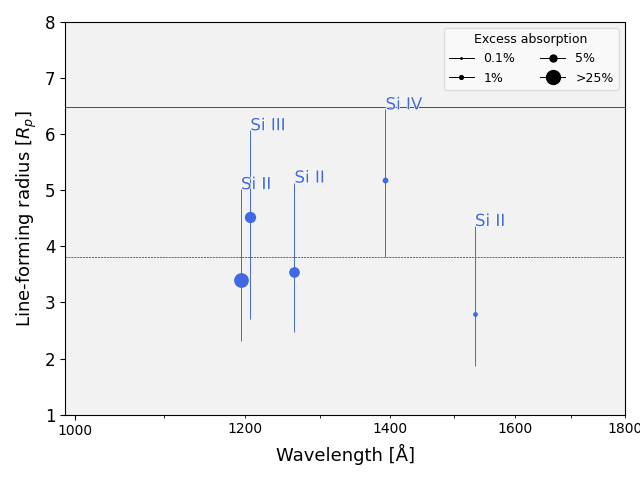

In [20]:
fig, ax = plt.subplots(1)

ax.axhline(sim.p.Rstar / sim.p.R, lw=.5, color='k', zorder=-10) #draw stellar radius
plot_lfas(ax, lfas, Rroche=sim.p.Rroche/sim.p.R, marker='o', capsize = None, fix_labels=False, markersize=None)
ax.set_xticks([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
ax.set_xticks([900, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900], minor=True)
ax.set_xticks([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
ax.set_xticks([900, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900], minor=True)
ax.set_xticklabels(['1000', '2000','','','','','','','',''], fontsize=10)
ax.set_xticklabels(['1000', '','1200','', '1400','', '1600','', '1800',''], minor=True)
ax.set_yticks([1,2,3,4,5,6,7,8])
ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'], fontsize=12)
fig.tight_layout()
ax.set_xlim(990,1800)
plt.show()